## Libraries

Here I am going to use pytorch and librosa to read and manipulate audio files and matplotlib to plot.

In [282]:
import librosa
import torchaudio
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

In [283]:
# matplotlib setup to work better with jupyter
%matplotlib inline
plt.ioff()

# use wider figures
plt.rcParams["figure.figsize"] = (20,3)

## Reading in Audio Data

The audio data in this example is my voice saying "Sally sells sea shells by the sea shore." Torchaudio's load function loads the data into a tensor, and normalizes the data into the range [-1.0,1.0]. It also extracts the sample rate which allows us to convert the sample index to a time value (in seconds).

In [284]:
data, sample_rate = torchaudio.load('audio_data.wav')
print(data, sample_rate)

tensor([[ 0.0303,  0.0304,  0.0275,  ..., -0.0466, -0.0338, -0.0416]]) 44100


## Waveforms

The simplest way to view audio data is to look directly at the waveform. For this example, this is done with matplotlib

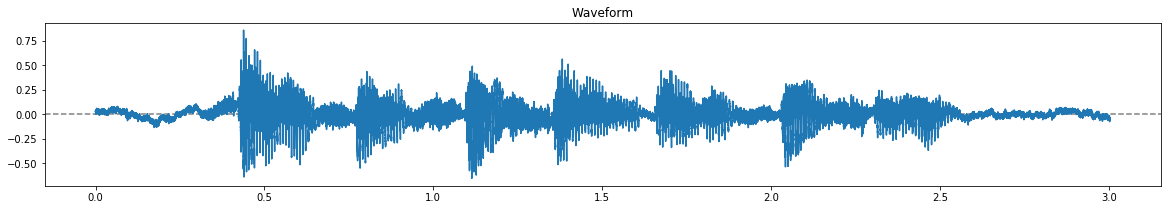

In [285]:
def get_axes(data,sample_rate):
    """
    Returns the number of samples, the squeezed data tensor, and time steps in seconds 
    """
    
    # Get the size of the data tensor
    size = data.size(-1)
    
    # Torch by default loads the data as a [1,num_samples] tensor, this corrects for that
    data = data.view(-1)
    
    # Get the x-axis values and divide by the sample rate to convert to seconds
    seconds = torch.arange(size)/sample_rate
    
    return size,data,seconds

def plot_waveform(data,sample_rate,title=None):
    """
    Plots a waveform given the sample data
    args:
        - data
            The waveform data, expected to be a tensor
        - sample_rate
            The sample rate of the original sound file
    """
    
    # Get the correct data to plot this waveform
    size,data,seconds = get_axes(data, sample_rate)
    
    # Draw a line at y=0 for reference and plot the data
    plt.axhline(y=0,linestyle="--", color="gray")
    if title:
        plt.title(title)
    plt.plot(torch.arange(size)/sample_rate, data)
    plt.show()
    

plot_waveform(data,sample_rate,"Waveform")

## Spectrograms

Spectrograms give insight into some of the acoustic and linguistic properties of sound. For instance, they show if the sound is voiced or unvoiced, vowel formants, stop closures, etc. We can use windows of varying length to show more or less frequency information in the spectrogram. Using a wider window will show the harmonics in better detail, while a narrower window will show only general formant information. The spectrograms below use the Hanning window function.

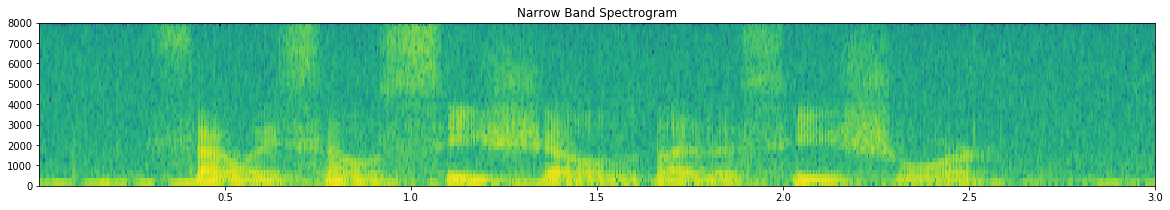

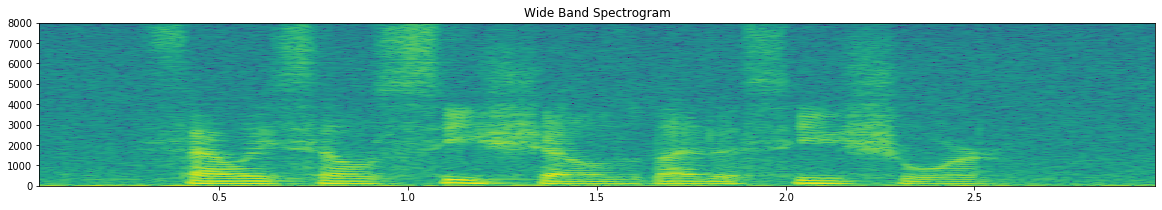

In [286]:
def plot_spectrogram(data,sample_rate,window_size=0.005, window_offset=0.0035,title=None,pitches=None):
    """
    Plots the spectrogram of a given waveform
    args:
        - data
            The waveform data, expected to be a tensor
        - sample_rate
            The sample rate of the original sound file
        - window_size
            The size of the window use to construct the spectrogram, expected to be in seconds
            defaults to 0.005s
    """
    
    # Get the correct data to plot this waveform
    size, data, seconds = get_axes(data, sample_rate)

    # Convert the window size from seconds to number of samples 
    # This must be an integer to plot properly
    window_size = int(sample_rate * window_size)
    
    # Convert the window offset from seconds to sample number
    window_offset = int(window_offset * sample_rate)
    
    # Allowing the window offset to be > window size would miss some data
    assert window_offset <= window_size, "Window off set must be <= window size!"
    
    # Plot the spectrogram
    plt.specgram(data, Fs=sample_rate, NFFT=window_size, noverlap=window_size-64)
    #plt.ylim(0,8000)
    if title:
        plt.title(title)
    plt.show()
    

from torchaudio.functional import *

# I'm resampling the data here so the spectrogram only shows up to 8000Hz,
# This isnt really necessary, but it may make the data easier to visualize
data = resample(data,sample_rate,16000)
sample_rate = 16000
    
# Show narrow band spectrogram
plot_spectrogram(data, 16000,0.005, title="Narrow Band Spectrogram")

# Show wide band spectrogram
plot_spectrogram(data, 16000,0.05, title="Wide Band Spectrogram")

## Other Visualizations
In addition to basic spectrograms, there are some slightly more advanced visualizations that may be helpful. 

### Mel Spectrogram
We can view the mel spectrogram, which is similar to a basic spectrogram, but accounts for the way humans perceive sound using a mel filter bank.

### Mel-Frequency Cepstral Coefficients
Mel-frequency cepstral coefficients (MFCCs) are a manner of separating the speech source from the filter that was applied to it. In effect, these attempt to remove the effects of f0, which (for the most part) does not really have an effect on speech perception.

### Linear Predictive Coding
Much like MFCCs, linear predictive coding attempts to recreate the filter that was applied to the source of speech. Visualizing these coefficients gives us a rough idea of what the spectral envelope looks like.

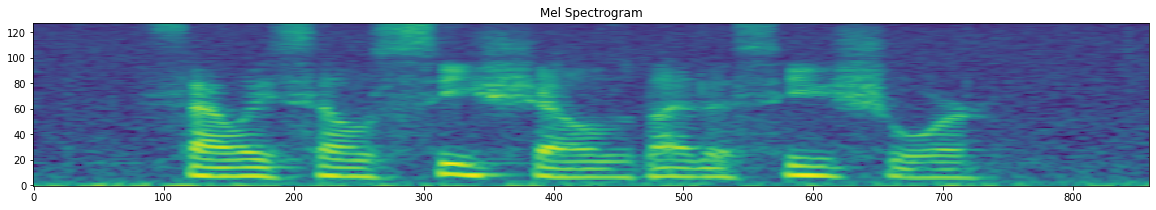

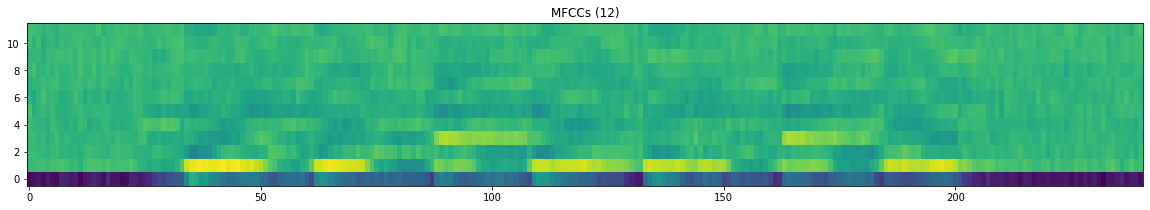

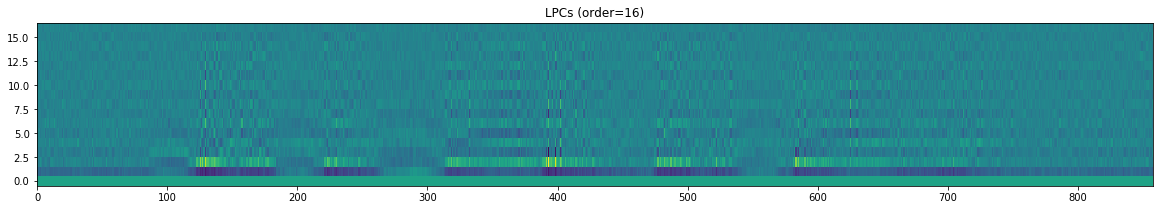

In [287]:
from torchaudio.transforms import *

def get_mel_spectrogram(data,window_offset=0.0035, title=None,sample_rate=16000):
    """
    Show the mel spectrogram of the given data
    args:
        - data
            waveform data
        - window_offset
            How far to move the frame window between frames
        - title
            Graph title
        - sample_rate
            The sample rate of this data
    """
    
    # Convert the window offset to number of samples
    window_offset = int(window_offset * sample_rate)
    
    # Get the transform, we default here to 128 mel filters and a window size of 1024
    transform = MelSpectrogram(sample_rate,pad_mode="reflect",onesided=True,n_mels=128,n_fft=1024, \
                               hop_length=window_offset)
    
    # Show the graph
    mel_spec = transform(data)
    plt.imshow(librosa.power_to_db(mel_spec[0]), origin="lower",aspect="auto") # aspect auto shows a wider plot
    if title:
        plt.title(title)
    plt.show()
    
def get_frames(data,frame_width=0.005,frame_offset=0.0035, sample_rate=16000):
    """
    Splits the provided data into frames
    args:
        - data
            Waveform data
        - frame_width
            Width of each frame, in seconds
        - frame_offset
            How far to move each frame, in seconds
        - sample_rate
            sample rate of the data
    """
    frames = []
    
    # Convert values from seconds to number of samples
    frame_width = int(frame_width * sample_rate)
    frame_offset = int(frame_offset * sample_rate)
    
    # Get the hanning window
    hann_window = torch.hann_window(frame_width).numpy()
    
    idx = 0
    # Loop until we cannot create another frame
    while idx + frame_width <= data.shape[0]:
        # Extract the frame and apply the window
        curr_frame = np.array(data[int(idx):int(idx+frame_width)])
        curr_frame = curr_frame * hann_window
        frames.append(curr_frame)
        idx += frame_offset
    
    # This pads the last frame so its the same width as the others
    curr_frame = np.array(data[idx:])
    curr_frame = np.pad(curr_frame,(0,frame_width - len(curr_frame)))
    curr_frame = curr_frame * hann_window
        
    frames.append(curr_frame)
    
    return np.array(frames)
    
def show_lpcs(data,frame_width=0.005,frame_offset=0.0035,sample_rate=16000,order=16,title=None):
    """
    Show the lpcs of the given data
    args:
        - data
            waveform data
        - frame_width
            the width of each frame (in seconds)
        - frame_offset
            How far to move the frame window between frames (in seconds)
        - sample_rate
            The sample rate of this data
        - title
            Graph title
    """
    data = data[0].numpy()
    
    # Theres no built in torch or librosa method to extract frames
    frames = get_frames(data,frame_width,frame_offset,sample_rate)
    
    lpcs = []
    
    # Get lpcs for every frame
    for frame in frames:
        lpcs.append(librosa.lpc(frame,order=order))
        
    lpcs = np.array(lpcs)
    
    # show the graph
    plt.imshow(lpcs.T, origin="lower",aspect="auto")
    if title:
        plt.title(title)
    plt.show()
    
def show_mfccs(data,num_mfcc=12,sample_rate=16000,title=None):
    """
    Show the mfccs for this data
    args:
        - data
            waveform data
        - num_mfccs
            Number of MFCCs to calculate (defaults to 12)
        - sample_rate
            Sample rate of the data
        - title
            Graph title
    """
    # Get the mfcc transform
    mfcc = MFCC(sample_rate,log_mels=True,n_mfcc=num_mfcc)
    
    # Calculate mfccs and show them
    mfccs = mfcc(data).squeeze(0)
    plt.imshow(mfccs, origin="lower",aspect="auto")
    if title:
        plt.title(title)
    plt.show()
    
get_mel_spectrogram(data,sample_rate=sample_rate,title="Mel Spectrogram")
show_mfccs(data,title="MFCCs (12)")
show_lpcs(data,order=16,title="LPCs (order=16)")

## Signal Manipulation

One of the easiest forms of signal manipulation is to apply filters to eliminate frequencies above or below a given range. We may use these to filter out frequencies outside the range of human hearing, or frequencies that are not necessary for speech perception. I will use these to filter out frequencies that are outside the general range of my vocal pitch, which happens to be between 40Hz and 170Hz.

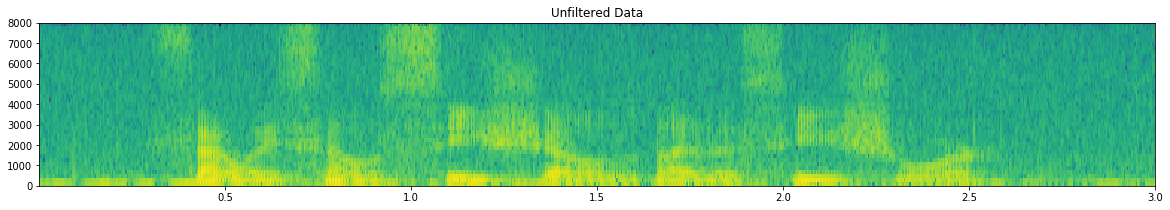

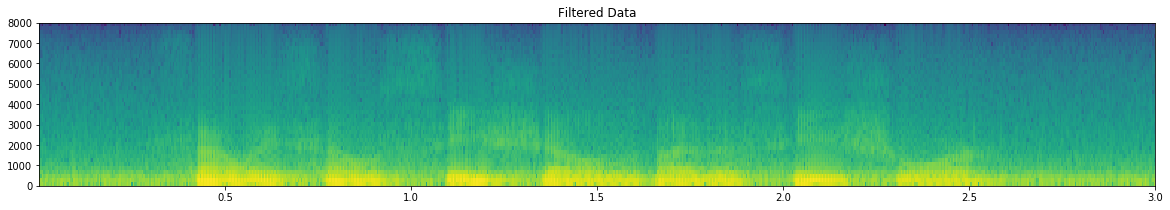

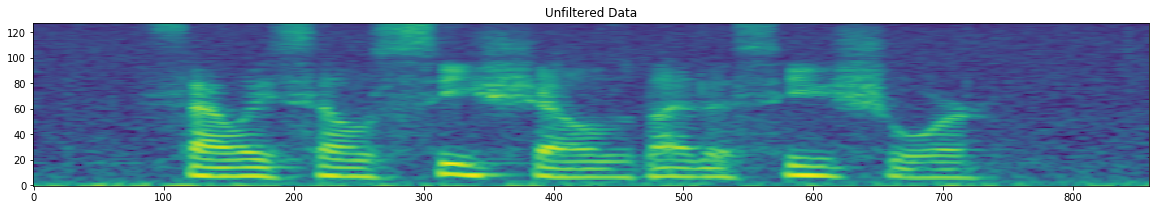

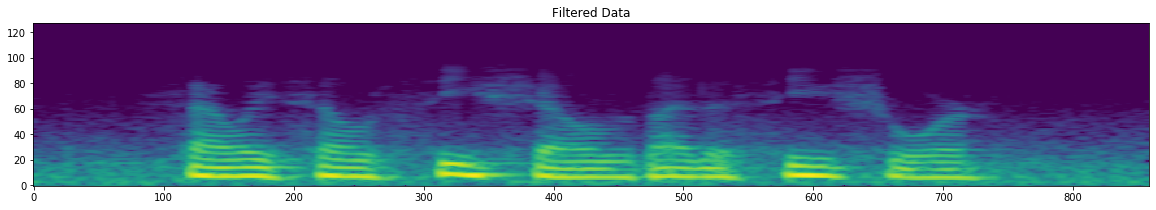

Unfiltered Data: 


Filtered Data: 


In [288]:
def f0_filter(data, high_cutoff=250, low_cutoff=50):
    """
    Attenuate frequencies outside of the provided frequency range
    args:
        - data
            waveform data
        - high_cutoff
            The bound of the low pass filter
        - low_cutoff
            The bound of the high pass filter
    """
    # Cutoff frequencies above 170Hz
    filtered_data = lowpass_biquad(data,sample_rate,high_cutoff)

    # Cutoff Frequencies below 40Hz
    filtered_data = highpass_biquad(filtered_data,sample_rate,low_cutoff)
    
    return filtered_data


filtered_data = f0_filter(data)
plot_spectrogram(data,sample_rate=sample_rate,title="Unfiltered Data")
plot_spectrogram(filtered_data,sample_rate=sample_rate,title="Filtered Data")
get_mel_spectrogram(data,sample_rate=sample_rate,title="Unfiltered Data")
get_mel_spectrogram(filtered_data,sample_rate=sample_rate,title="Filtered Data")
print("Unfiltered Data: ")
display(Audio(data,rate=sample_rate))
print("Filtered Data: ")
display(Audio(filtered_data,rate=sample_rate))

With unlikely f0 frequencies attenuated, we can do pitch tracking on the filtered signal. It is not necessary to filter the signal to apply pitch tracking, but it can make it more acurrate.

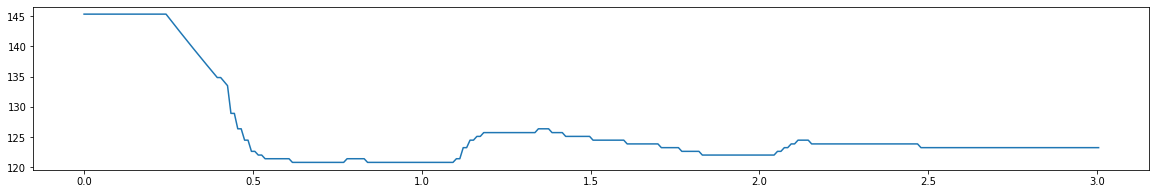

In [289]:
def plot_pitch(data, sample_rate):
    
    """
    Plot pitch tracking
     - data
         The waveform data
     - sample_rate
         Sample rate of the original data
    """
    # Kaldi pitch is better for ASR than the standard torch implementation
    f0_tracking = compute_kaldi_pitch(data,sample_rate)
    
    final_time = data.size(-1) / sample_rate
    # This extracts the actual pitch frequency values
    f0_tracking = f0_tracking[...,1]
    
    # Get the time steps for the x-axis
    time_steps = torch.linspace(0,final_time,f0_tracking.size(-1))
    plt.plot(time_steps,f0_tracking[0])
    plt.show()

plot_pitch(filtered_data,sample_rate)

## Pitch Shifting
Pitch shifting simply adjust the fundamental frequency of a given signal. I have shifted the pitch of my voice up a musical fifth, or roughly 1.5 times the original fundamental frequency. Pytorch's method does use a dft to shift the pitch, but other methods like TD-PSOLA can manipulate f0 in the time domain and can be computationally more efficient.

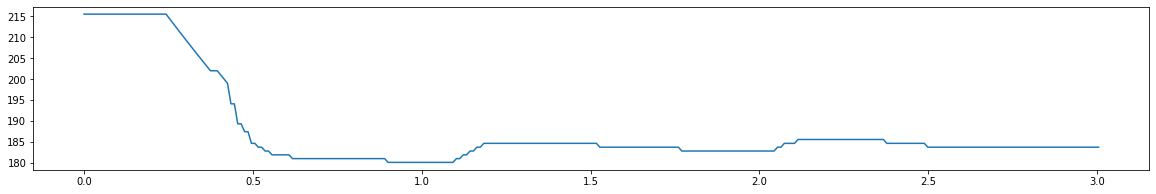

Pitch-shifted data: 


In [290]:
pitch_shifted = pitch_shift(data,sample_rate,7)
filtered_pitch = f0_filter(pitch_shifted,300,100)
plot_pitch(filtered_pitch, sample_rate)
print("Pitch-shifted data: ")
display(Audio(pitch_shifted,rate=sample_rate))

## Noise Addition
Often with smaller data sets, it can be advantageous to create new data based on old data. One way to do this is to add some gaussian noise to the signal. Though the recording I am using is already pretty noisy already, we should still be able to hear my voice after adding more

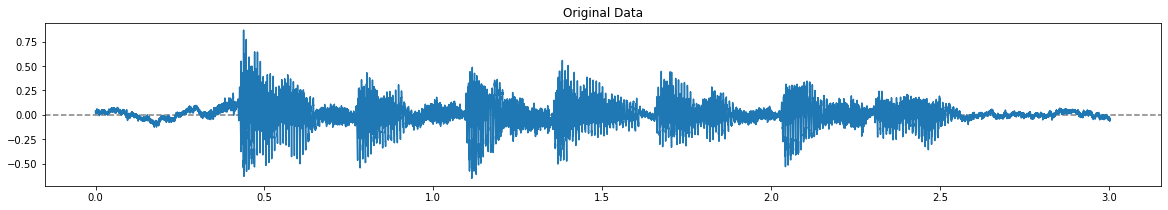

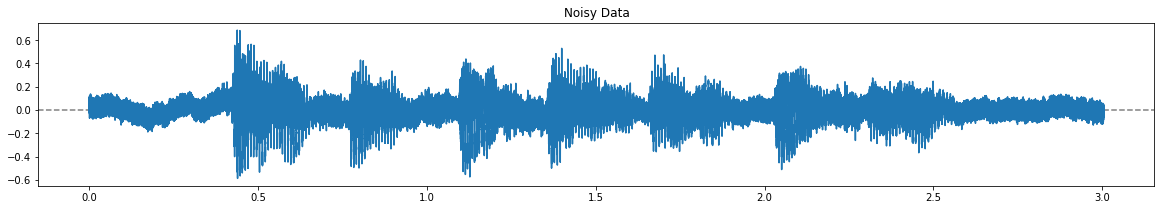

Noisy Audio: 


In [291]:
def add_noise(data,noise_factor=0.1):
    """
    Adds Gaussian noise to the signal
    Args:
        - data
            Waveform data
        - noise_factor
            How much noise we want to add
    """
    # Get the current max point, we want the max to be the same after applying noise
    max_point = torch.max(data)
    
    # Get a noise array between -1 and 1
    noise = (torch.rand(data.size(-1)) * 2) - 1
    
    # Apply the noise factor
    noise = noise * noise_factor
    
    # Add the noise
    noisy = data + noise
    
    # Renormalize the data so its in the same range it was before
    new_max = torch.max(noisy)
    noisy *= (new_max/max_point)
    
    return noisy

noisy = add_noise(data)
plot_waveform(data,sample_rate,title="Original Data")
plot_waveform(noisy,sample_rate,title="Noisy Data")
print("Noisy Audio: ")
display(Audio(noisy,rate=sample_rate))

## Adding Effects
Noise supression is easy to implement and works well enough, but often we want to be more discerning in the type of effects we can add. In fact, pytorch gives us an API to use SoX, a command line audio manipulation interface to add more complex effects.

### Room Reverb
We can apply a reveb effect to our speech data to simulate speech in a large, empty room

In [292]:
from torchaudio.sox_effects import apply_effects_tensor

reverb_data,sample_rate = apply_effects_tensor(data, sample_rate, [["reverb","20"]])
print("Data with added reverb: ")
display(Audio(reverb_data,rate=sample_rate))

Data with added reverb: 


### Audio Speed
SoX can also adjust how fast the audio is played (note that librosa can do this as well) 

In [293]:
speed_up,sr = apply_effects_tensor(data,sample_rate, [["speed","1.5"]])
print("Sped up data: ")
display(Audio(speed_up,rate=sr))

slow_down,sr = apply_effects_tensor(data,sample_rate, [["speed","0.5"]])
print("Slowed down data: ")
display(Audio(slow_down,rate=sr))

Sped up data: 


Slowed down data: 


### Silence Removal
It is often wise to remove silence from the beginning and ends of audio samples. This must be used with caution though, because it can be difficult to detect silence in noisy audio data. SoX makes it difficult to remove silence from the end of a file, but Pytorch allows us to create a pipeline of SoX commands. We can remove silence from the beginning, reverse the sample, and remove silence from the beginning again, and reverse it back.

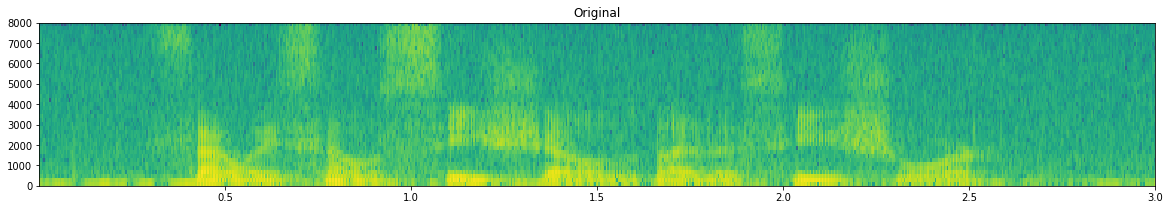

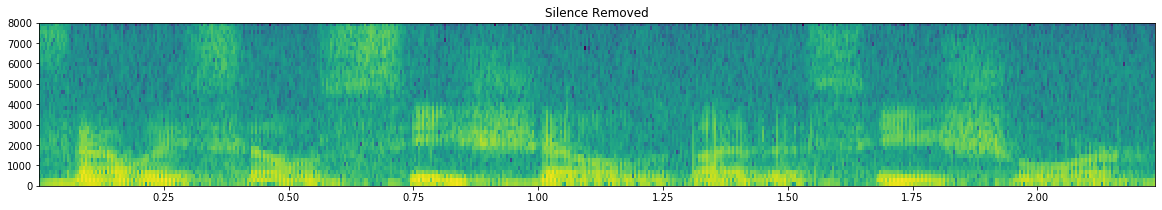

With silence removed: 


In [297]:
sil_removed,sample_rate = apply_effects_tensor(data,sample_rate,[["silence","1","0.3","2%"],
                                                                 ["reverse"],
                                                                 ["silence","1","0.3","2%"],
                                                                 ["reverse"]])

plot_spectrogram(data,sample_rate,title="Original")
plot_spectrogram(sil_removed,sample_rate,title="Silence Removed")
print("With silence removed: ")
display(Audio(sil_removed,rate=sample_rate))